## Introduction to convnets

Let's start by creating a simple covnets for MNIST digit dataset.

In [1]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of
shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of channels is controlled by the first
argument passed to the Conv2D layers (32 or 64).
The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely
connected classifier network: a stack of Dense
layers. These classifiers process vectors, which are 1D, whereas the current output is a
3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

As you can see, the (3, 3, 64) outputs are flattened into vectors of shape (576,)
before going through two Dense layers.

Now, let’s train the convnet on the MNIST digits. 

In [2]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [13]:
model.compile(optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 38s 34ms/step - loss: 0.0158 - accuracy: 0.9954
Epoch 2/5
938/938 [==============================] - 31s 33ms/step - loss: 0.0118 - accuracy: 0.9964
Epoch 3/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0089 - accuracy: 0.9969
Epoch 4/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0082 - accuracy: 0.9975
Epoch 5/5
938/938 [==============================] - 37s 39ms/step - loss: 0.0070 - accuracy: 0.9979


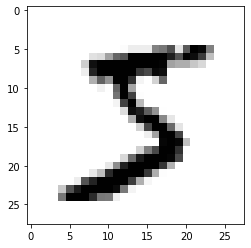

In [15]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0], cmap=plt.cm.binary)

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 6s 6ms/step - loss: 0.0347 - accuracy: 0.9917


In [11]:
test_acc

0.9896000027656555

About 99% of accuracy, even for this simple model!

But why does this simple convnet work so well, compared to a densely connected
model? To answer this, let’s dive into what the `Conv2D` and `MaxPooling2D` layers do.

### The convolution operation

The fundamental difference between a densely connected layer and a convolution
layer is this: `Dense` layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn
local patterns: in the case of images, patterns found in small 2D windows of the inputs. In the previous example, these windows were all 3 × 3.

![](img/04_01.png)

This key characteristic gives convnets two interesting properties:
* *The patterns they learn are translation invariant*: After learning a certain pattern in
the lower-right corner of a picture, a convnet can recognize it anywhere: for
example, in the upper-left corner. A densely connected network would have to
learn the pattern anew if it appeared at a new location.
* *They can learn spatial hierarchies of patterns*: A first convolution layer
will learn small local patterns such as edges, a second convolution layer will
learn larger patterns made of the features of the first layers, and so on. This
allows convnets to efficiently learn increasingly complex and abstract visual concepts

![](img/04_02.png "Hierarchical feature maps")

Convolutions operate over 3D tensors, called *feature maps*, with two spatial axes (height
and width) as well as a depth axis (also called the channels axis). The convolution operation extracts patches from its input feature
map and applies the same transformation to all of these patches, producing an output
feature map. This output feature map is still a 3D tensor: it has a width and a height. Its
depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB
input; rather, they stand for filters. Filters encode specific aspects of the input data: at a
high level, a single filter could encode the concept “presence of a face in the input,”
for instance.

In the MNIST example, the first convolution layer takes a feature map of size (28,
28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its
input. Each of these 32 output channels contains a 26 × 26 grid of values, which is a
response map of the filter over the input, indicating the response of that filter pattern at
different locations in the input.

![](img/04_03.png)

Convolutions are defined by two key parameters:
* *Size of the patches extracted from the inputs*—These are typically 3 × 3 or 5 × 5. In the
example, they were 3 × 3, which is a common choice.
* *Depth of the output feature map*—The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the 3D input
feature map, stopping at every possible location, and extracting the 3D patch of surrounding features (shape (window_height, window_width, input_depth)). Each
such 3D patch is then transformed (via a tensor product with the same learned weight
matrix, called the convolution kernel) into a 1D vector of shape (output_depth,). All of
these vectors are then spatially reassembled into a 3D output map of shape (height,
width, output_depth). Every spatial location in the output feature map corresponds
to the same location in the input feature map (for example, the lower-right corner of
the output contains information about the lower-right corner of the input). For
instance, with 3 × 3 windows, the vector output[i, j, :] comes from the 3D patch
input[i-1:i+1, j-1:j+1, :]

#### UNDERSTANDING BORDER EFFECTS AND PADDING

Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you
can center a 3 × 3 window, forming a 3 × 3 grid. Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension,
in this case.

![](img/04_04.png "Valid locations of 3 × 3 patches in a 5 × 5 input feature map")

If you want to get an output feature map with the same spatial dimensions as the
input, you can use padding. Padding consists of adding an appropriate number of rows
and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile

![](img/04_05.png "Padded input feature map")

In Conv2D layers, padding is configurable via the `padding` argument, which takes two
values: `"valid"`, which means no padding (only valid window locations will be used);
and `"same"`, which means “pad in such a way as to have an output with the same width
and height as the input.” 

#### UNDERSTANDING CONVOLUTION STRIDES

The distance between two successive windows is a parameter of the
convolution, called its stride, which defaults to 1. It’s possible to have strided convolutions: convolutions with a stride higher than 1. You can see the patches
extracted by a 3 × 3 convolution with stride 2 over a 5 × 5 input (without padding)

![](img/04_06.png "3 × 3 convolution patches with 2 × 2 strides")

### The max-pooling operation

Pooling layers are used as the purpose of gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network. Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It’s conceptually similar to convolution, except
that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation.

Note that max pooling isn’t the only way you can achieve such downsampling. As
you already know, you can also use strides in the prior convolution layer. And you can use average pooling instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the
max. But max pooling tends to work better than these alternative solutions.

## Training a convnet from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation. As a practical example, we’ll focus on classifying
images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000
cats, 2,000 dogs). We’ll use 2,000 pictures for training—1,000 for validation, and
1,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: training a new
model from scratch using what little data you have. You’ll start by naively training a
small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracy of 71%. At
that point, the main issue will be overfitting. Then we’ll introduce data augmentation, a
powerful technique for mitigating overfitting in computer vision. By using data augmentation, you’ll improve the network to reach an accuracy of 82%.

In the next section, we’ll review two more essential techniques for applying deep
learning to small datasets: feature extraction with a pretrained network (which will get you
to an accuracy of 90% to 96%) and fine-tuning a pretrained network (this will get you to a
final accuracy of 97%). 

### The relevance of deep learning for small-data problems

It isn’t possible to train a convnet to solve a
complex problem with just a few tens of samples, but a few hundred can potentially
suffice if the model is small and well regularized and the task is simple. Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still
yield reasonable results despite a relative lack of data, without the need for any custom
feature engineering. 

### Downloading the data

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when
convnets weren’t mainstream.  You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data 

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and
is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new
dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

In [3]:
import os, shutil

original_dataset_dir = r"C:\Users\harik\Downloads\train"
base_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small"

os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [1]:
train_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\train"
validation_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\validation"
test_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\test"
train_cats_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\train\cats"
train_dogs_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\train\dogs"
validation_cats_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\validation\cats"
validation_dogs_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\validation\dogs"
test_cats_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\test\cats"
test_dogs_dir = r"C:\Users\harik\Downloads\cats_and_dogs_small\test\dogs"

In [2]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total testing cat images:', len(os.listdir(test_cats_dir)))
print('total testing dog images:', len(os.listdir(test_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total testing cat images: 500
total testing dog images: 500
total validation cat images: 500
total validation dog images: 500


### Building The Network

You’ll reuse the same general structure: the convnet will be a
stack of alternated `Conv2D` (with relu activation) and `MaxPooling2D` layers.
But because you’re dealing with bigger images and a more complex problem, you’ll
make your network larger, accordingly: it will have one more `Conv2D` + `MaxPooling2D`
stage. This serves both to augment the capacity of the network and to further reduce
the size of the feature maps so they aren’t overly large when you reach the Flatten
layer.

In [5]:
from keras import layers
from keras import models

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

Since you
ended the network with a single sigmoid unit, you’ll use binary crossentropy as the
loss .

In [26]:
model.compile(loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['acc'])

### Data preprocessing

Data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the network. Currently, the data sits on a drive as
JPEG files, so the steps for getting it into the network are roughly as follows:
1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
neural networks prefer to deal with small input values).

Keras has utilities to take care of these
steps automatically. Keras has a module with image-processing helper tools, located at
`keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator`,
which lets you quickly set up Python generators that can automatically turn image files
on disk into batches of preprocessed tensors.

In [17]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of 150 × 150 RGB
images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). There are 20 samples in each batch (the batch size).

In [24]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model to the data using the generator. You do so using the `fit`
method, the equivalent of fit for data generators like this one. It expects as its first
argument a Python generator that will yield batches of inputs and targets indefinitely,
like this one does. Because the data is being generated endlessly, the Keras model
needs to know how many samples to draw from the generator before declaring an
epoch over. This is the role of the `steps_per_epoch` argument.

When using `fit`, you can pass a `validation_data` argument, much as
with the fit method. If you pass a generator as
`validation_data`, then this generator is expected to yield batches of validation data
endlessly; thus you should also specify the `validation_steps` argument.

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
100/100 [==============================] - 78s 692ms/step - loss: 0.8576 - acc: 0.5019 - val_loss: 0.6915 - val_acc: 0.6230
Epoch 2/30
100/100 [==============================] - 63s 618ms/step - loss: 0.7018 - acc: 0.5972 - val_loss: 0.7901 - val_acc: 0.5400
Epoch 3/30
100/100 [==============================] - 69s 669ms/step - loss: 0.6703 - acc: 0.6132 - val_loss: 0.6399 - val_acc: 0.6370
Epoch 4/30
100/100 [==============================] - 82s 803ms/step - loss: 0.5984 - acc: 0.6981 - val_loss: 0.8919 - val_acc: 0.5440
Epoch 5/30
100/100 [==============================] - 82s 786ms/step - loss: 0.5559 - acc: 0.7180 - val_loss: 0.5952 - val_acc: 0.6720
Epoch 6/30
100/100 [==============================] - 91s 861ms/step - loss: 0.5285 - acc: 0.7319 - val_loss: 0.5689 - val_acc: 0.7100
Epoch 7/30
100/100 [==============================] - 81s 768ms/step - loss: 0.4569 - acc: 0.7921 - val_loss: 0.5873 - val_acc: 0.6830
Epoch 8/30
100/100 [==============================] - 8

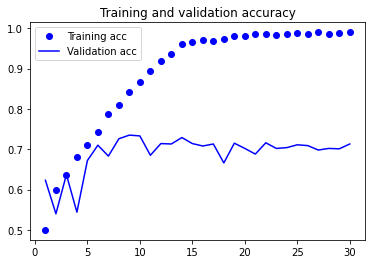

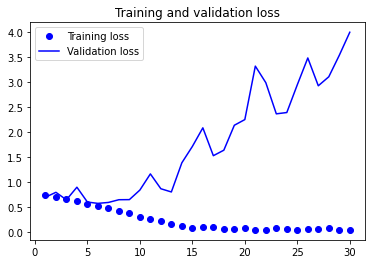

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly
over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%.
The validation loss reaches its minimum after only five epochs and then stalls, whereas
the training loss keeps decreasing linearly until it reaches nearly 0.

We’re now
going to work with a new one, specific to computer vision and used almost universally
when processing images with deep-learning models: *data augmentation*.

### Using data augmentation

Data augmentation takes the approach of generating more training data
from existing training samples, by augmenting the samples via a number of random
transformations that yield believable-looking images. The goal is that at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to
be performed on the images read by the `ImageDataGenerator` instance. Let’s get
started with an example.

In [29]:
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation).
Let’s quickly go over this code:
* `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or
height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example,
real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can
appear after a rotation or a width/height shift.

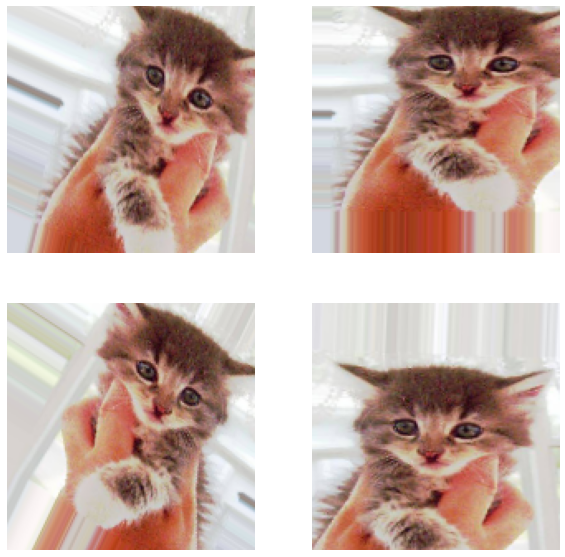

In [38]:
from keras.preprocessing import image
fnames = [os.path.join(train_cats_dir, fname) for
fname in os.listdir(train_cats_dir)]
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
plt.figure(figsize=(10,10))
for batch in datagen.flow(x, batch_size=1):
    f = plt.subplot(2,2,i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis(False)
    i += 1
    if i % 4 == 0:
        break

If you train a new network using this data-augmentation configuration, the network
will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not
be enough to completely get rid of overfitting. To further fight overfitting, you’ll also
add a `Dropout` layer to your model, right before the densely connected classifier.

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['acc'])

Let’s train the network using data augmentation and dropout.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
63/63 [==============================] - 87s 1s/step - loss: 0.8680 - acc: 0.5166 - val_loss: 0.6924 - val_acc: 0.5070
Epoch 2/30
63/63 [==============================] - 84s 1s/step - loss: 0.7078 - acc: 0.5206 - val_loss: 0.6882 - val_acc: 0.5590
Epoch 3/30
63/63 [==============================] - 117s 2s/step - loss: 0.7120 - acc: 0.5439 - val_loss: 0.6486 - val_acc: 0.6190
Epoch 4/30
63/63 [==============================] - 87s 1s/step - loss: 0.6676 - acc: 0.6109 - val_loss: 0.6429 - val_acc: 0.6240
Epoch 5/30
63/63 [==============================] - 81s 1s/step - loss: 0.6910 - acc: 0.6255 - val_loss: 0.6170 - val_acc: 0.6540
Epoch 6/30
63/63 [==============================] - 83s 1s/step - loss: 0.6519 - acc: 0.6174 - val_loss: 0.6090 - val_acc: 0.6590
Epoch 7/30
63/63 [==============================] - 95s 1s/step - loss: 0.6426 - acc: 0.6392 - val_loss: 0.5873 - val_acc: 0.6990
Epoch

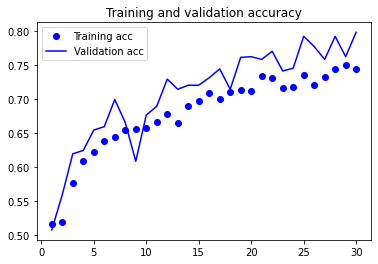

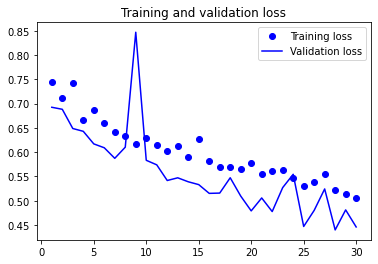

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

It reaches accuracy of about 80%. Greater than the 72% obtained by the earlier model.

## Using a pretrained convnet

A common and highly effective approach to deep learning on small image datasets is
to use a pretrained network. A pretrained network is a saved network that was previously
trained on a large dataset, typically on a large-scale image-classification task. If this
original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the
visual world, and hence its features can prove useful for many different computervision problems, even though these new problems may involve completely different
classes than those of the original task. For instance, you might train a network on
ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in
images.

You’ll use the VGG16 architecture. It’s a simple and widely used convnet architecture for ImageNet.1
Although it’s an older model, far from the current state of the art and somewhat
heavier than many other recent models, we chose it because its architecture is similar to
what you’re already familiar with and is easy to understand without introducing any
new concepts. This may be your first encounter with one of these cutesy model
names—VGG, ResNet, Inception, Inception-ResNet, Xception, and so on; you’ll get
used to them, because they will come up frequently if you keep doing deep learning
for computer vision.

There are two ways to use a pretrained network: feature extraction and fine-tuning.
We’ll cover both of them. Let’s start with feature extraction.

### Feature extraction

Feature extraction consists of using the representations learned by a previous network
to extract interesting features from new samples. These features are then run through
a new classifier, which is trained from scratch. Convnets used for image classification comprise two parts:
they start with a series of pooling and convolution layers, and they end with a densely
connected classifier. The first part is called the convolutional base of the model. In the
case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

![](img/04_07.png 'Swapping classifiers while keeping the same convolutional base')

Why only reuse the convolutional base? Could you reuse the densely connected classifier as well? In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore
more reusable: the feature maps of a convnet are presence maps of generic concepts
over a picture, which is likely to be useful regardless of the computer-vision problem at
hand. But the representations learned by the classifier will necessarily be specific to the
set of classes on which the model was trained—they will only contain information about
the presence probability of this or that class in the entire picture. 

Layers that come earlier in the model extract local, highly generic feature
maps (such as visual edges, colors, and textures), whereas layers that are higher up
extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset
differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than
using the entire convolutional base.

The VGG16 model, among others, comes prepackaged with Keras. You can import
it from the `keras.applications` module. Here’s the list of image-classification
models (all pretrained on the ImageNet dataset) that are available as part of `keras.applications`:
* **Xception**
* **Inception V3**
* **ResNet50**
* **VGG16**
* **VGG19**
* **MobileNet**

In [10]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 11s 0us/step


In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     